# Imports

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [7]:
hashed_df = pd.read_csv('hashed_feature.csv')
tabular_df = pd.read_csv('tabular_data.csv')
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

Since we have periods for each ID in our data, we need to restructure the table. We will do it in 2 ways:
- calculate mean values of 12 periods for each ID
- restructure/pivot the table so we have separate feature column for every period (like 'feature_1_period_1', 'feature_1_period_2' ...)

Also we will use Logistic Regression and SVM for predicting results.
So in total we are going build 4 models, measure how effective they are for predicting outcomes and we will select the most effective. 

# Data preparation

In [8]:
# Simplest solution to deal with NaN/empty cells
tabular_df = tabular_df.fillna(axis='columns', method='bfill')

## Dealing with strings in columns

In entire feature_25 column strings/hashes are the same as in other columns, so  we can create a dictionary of them)

In [9]:
# Group/filter feature_25 column that contains string values and create unique str names and a dictionary dataframe
str_dict_df = pd.DataFrame(tabular_df['feature_25'].unique(), columns = ['feature_25'])

# Create a new 'id' column, set 'feature_25' as a key and 'str_id' as a value to for easier future replacement/matching
# Drop index name and create a new 'id' column based on indexes
str_dict_df.reset_index(level=0, inplace=True)
str_dict_df = str_dict_df.set_index('feature_25')
str_dict_df.index.name = None
str_dict_df = str_dict_df.rename(columns = {'index': 'id'})

# Convert dictionary dataframe into actual python dictionary while also transposing it
# It is needed for mapping them to replace hash codes with integer values - that can be used for model algorithm to evaluate them, it shouldn't be possible with just hashes as strings (from what I understand)

str_codes = str_dict_df.T.to_dict('list')

# Convert lists to integers
for key, value in str_codes.items():
    str_codes[key] = value[0]

# Encode (map) main tabular dataframe with integer id's from string dictionary we created above
for column in tabular_df:
   tabular_df[column] = tabular_df[column].map(str_codes).fillna(tabular_df[column])

## Create a pivoted table with feature columns for each period

In [10]:
tabular_df_round = tabular_df.astype({'period': int, 'id': int}).astype({'period': str})

# Get all column names
column_names_list = []
for column in tabular_df_round.columns[2:]:
    column_names_list.append(column)

# Feature columns are sorted the wrong way - 1 2 3 ... 8 9 are in the end (after 41 42 43), but that shouldn't matter
tabular_df_pivoted = pd.pivot_table(tabular_df_round, index=['id'], columns=['period'], values=column_names_list)
tabular_df_pivoted = tabular_df_pivoted.reset_index()

# Join/stack/merge column levels and set readable names for them
tab_df_piv_joined_col_names = tabular_df_pivoted
tab_df_piv_joined_col_names.columns = ['_per_'.join((j,k)) for j,k in tab_df_piv_joined_col_names.columns]

# Rename ID column
tab_df_piv_joined_col_names = tab_df_piv_joined_col_names.rename(columns={'id_per_': 'id'})

tab_df_piv_joined_col_names.head(3)
tabular_df_all = tab_df_piv_joined_col_names

## Create a table with mean values of 12 periods

In [11]:
tabular_df_means = tabular_df.groupby([tabular_df['id']]).mean()
tabular_df_means.reset_index(level=0, inplace=True)
tabular_df_means.head()

,id,period,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,0,6.5,110.000000,60.916667,0.238880,293.635812,430.134167,0.000000,0.445332,147.666667,...,0.425000,0.0,11.535962,0.000000,59.875000,0.750000,8.965738,142.833333,315.011667,0.250000
1,1,6.5,110.000000,135.541667,0.060443,6940.579852,1119.352500,0.000000,0.350638,1199.843333,...,1.636667,0.0,3385.043551,0.083333,125.000000,6.750000,15.637394,135.916667,204.334131,204.334131
2,2,6.5,110.166667,0.597500,0.574959,0.141369,4.168333,0.000000,0.875014,10.166667,...,0.456667,0.0,0.000082,0.000000,0.597500,0.000000,0.345516,10.083333,2.470000,0.000000
3,3,6.5,28.199112,16.324112,357.412960,379.234397,19.188810,0.285477,21.883435,41.372977,...,0.170000,0.0,0.163807,0.666667,51.376667,1.000000,0.690459,106.000000,55.316667,6.666667
4,4,6.5,110.000000,126.000000,0.133693,2568.283478,460.332500,0.000000,1.006855,522.449167,...,3.381667,0.0,162.972195,0.166667,103.733333,36.333333,17.000910,190.333333,208.911004,208.911004


# Dealing with hashes table
Create hash dictionary to encode them in the tabular data

In [12]:
# Group/filter so unique hash names and create a 'dictionary' dataframe
unique_hashes_df = pd.DataFrame(hashed_df.feature_50.unique(), columns = ['feature_50'])

hashes_dict_df = unique_hashes_df
# Create a new 'id' column, set 'feature_50' as a key and 'hash_id' as a value to for easier future replacement/matching
# Drop index name and create a new 'id' column based on indexes

hashes_dict_df.reset_index(level=0, inplace=True)
hashes_dict_df = hashes_dict_df.set_index('feature_50')
hashes_dict_df.index.name = None
hashes_dict_df = hashes_dict_df.rename(columns = {'index': 'id'})

# Convert dictionary dataframe into actual python dictionary while also transposing it 
# It is needed for mapping them to replace hash codes with integer values 
# That can be used for model algorithm to evaluate them, 
# It shouldn't be  possible with just hashes as strings (from what I understand)
hash_codes = hashes_dict_df.T.to_dict('list')

# Convert list to integers
for key, value in hash_codes.items():
    hash_codes[key] = value[0]

Encode (map) main hash table with integer id's from above dictionary

In [14]:
hashed_df['feature_50'] = hashed_df['feature_50'].map(hash_codes)
hashed_df_grouped = hashed_df.groupby('id')['feature_50'].apply(list)

Now join main tabular_df with hashes

In [32]:
joined_df = pd.merge(tabular_df_means, hashed_df_grouped, on='id')

# Create a new column where we put number (count) of hashes
joined_df['hashes_count'] = [len(x) for x in joined_df['feature_50']]

# Create a new column where we put number (count) of unique hashes
joined_df['hashes_unique_count'] = [len(set(x)) for x in joined_df['feature_50']]

# Check if there are differences between hashes count and unique hashes count
def checkDiff(x, y):
    if x == y:
        return 0
    else:
        return 1

joined_df['hash_diff'] = np.vectorize(checkDiff)(joined_df['hashes_count'], joined_df['hashes_unique_count'])

# Check how many diff's do we have in total
print(joined_df['hash_diff'].sum())

0


As we can see, all hashes for each 'id' in hashed_df table are unique - there are no difference between those 2 columns. So we are not able to extract additional features and we will use only hashes count column. If only we know what data/information those hashes contain, we can create way more sophisticated algo to extract/vectorize them. For example, if those hashes are voice recognized words (or just words from SMS) we can rank them to set priorities/ranks. That way we can create additional column like 'hashes_rank' etc.

## Create two final dataframes we are going to build models on

In [33]:
# Means of periods
tabular_df_means = joined_df
tabular_df_means = tabular_df_means.drop(['feature_50', 'hashes_unique_count', 'hash_diff'], axis=1)
tabular_df_means.head()

,id,period,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,hashes_count
0,0,6.5,110.000000,60.916667,0.238880,293.635812,430.134167,0.000000,0.445332,147.666667,...,0.0,11.535962,0.000000,59.875000,0.750000,8.965738,142.833333,315.011667,0.250000,10
1,1,6.5,110.000000,135.541667,0.060443,6940.579852,1119.352500,0.000000,0.350638,1199.843333,...,0.0,3385.043551,0.083333,125.000000,6.750000,15.637394,135.916667,204.334131,204.334131,43
2,2,6.5,110.166667,0.597500,0.574959,0.141369,4.168333,0.000000,0.875014,10.166667,...,0.0,0.000082,0.000000,0.597500,0.000000,0.345516,10.083333,2.470000,0.000000,15
3,3,6.5,28.199112,16.324112,357.412960,379.234397,19.188810,0.285477,21.883435,41.372977,...,0.0,0.163807,0.666667,51.376667,1.000000,0.690459,106.000000,55.316667,6.666667,6
4,4,6.5,110.000000,126.000000,0.133693,2568.283478,460.332500,0.000000,1.006855,522.449167,...,0.0,162.972195,0.166667,103.733333,36.333333,17.000910,190.333333,208.911004,208.911004,52


In [34]:
# Periods in columns
tabular_df_all = pd.merge(tabular_df_all, hashed_df_grouped, on='id')
tabular_df_all['hashes_count'] = [len(x) for x in tabular_df_all['feature_50']]
tabular_df_all = tabular_df_all.drop(['feature_50'], axis=1)

In [20]:
tabular_df_all.head()

,id,feature_0_per_1,feature_0_per_10,feature_0_per_11,feature_0_per_12,feature_0_per_2,feature_0_per_3,feature_0_per_4,feature_0_per_5,feature_0_per_6,...,feature_9_per_12,feature_9_per_2,feature_9_per_3,feature_9_per_4,feature_9_per_5,feature_9_per_6,feature_9_per_7,feature_9_per_8,feature_9_per_9,hashes_count
0,0,110.0,110.000000,110.000000,110.000000,110.0,110.0,110.000000,110.000000,110.000000,...,3.020000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10
1,1,110.0,110.000000,110.000000,110.000000,110.0,110.0,110.000000,110.000000,110.000000,...,8.750000,8.75,0.00,4767.378484,3.170000,0.150000,0.000000,0.520000,1.800000,43
2,2,110.0,110.000000,110.000000,110.000000,110.0,111.0,110.000000,111.000000,110.000000,...,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15
3,3,110.0,0.272468,0.971221,0.556268,110.0,110.0,0.979337,0.140671,0.044753,...,0.556268,3.98,0.47,0.979337,0.140671,0.044753,0.206769,0.203066,0.051168,6
4,4,110.0,110.000000,110.000000,110.000000,110.0,110.0,110.000000,110.000000,110.000000,...,25.180000,70.20,78.82,59.630000,68.020000,52.850000,36.030000,14.330000,38.770000,52


# Building models

## Logistic Regression

In [38]:
df_train = pd.merge(tabular_df_means, train_df, on='id')

# Split train into train/test to test our model (coz we don't have correct answer in our test dataset - its empty and supposed to filled by us and sent for review)
df_train, df_test = train_test_split(df_train, test_size=0.2) 

y = df_train['target']
X = df_train.drop(['period', 'id', 'target'], axis=1).fillna(method='bfill')

model = LogisticRegression(random_state=0, solver='newton-cg', multi_class='multinomial').fit(X, y)
print('Logistic Regr Means Score: ', model.score(X, y))

# Same thing, but for columns with all periods
df_train_all = pd.merge(tabular_df_all, train_df, on='id')

df_train_all, df_test_all = train_test_split(df_train_all, test_size=0.2)

y_all = df_train_all['target']
X_all = df_train_all.drop(['id', 'target'], axis=1).fillna(method='bfill')

model_all = LogisticRegression(random_state=0, solver='newton-cg', multi_class='multinomial').fit(X_all, y_all)
print('Logistic Regr All-periods Score: ', model_all.score(X_all, y_all))

Logistic Regr Means Score:  0.7581879400061218
Logistic Regr All-periods Score:  0.8157330884603612


In [39]:
# Prediction for means of periods

X_pred = df_test.drop(['period', 'id', 'target'], axis=1).fillna(method='bfill')

res = model.predict_proba(X_pred)[:,1]

# Predictions for all periods included

X_pred_all = df_test_all.drop(['id', 'target'], axis=1).fillna(method='bfill')

res_all = model_all.predict_proba(X_pred_all)[:,1]

In [40]:
# Calc ROC AUC score for Logistic Regression (means of periods)
y_true = df_test['target']
y_scores = res
print(f'ROC AUC score for logistic regression (means): {roc_auc_score(y_true, y_scores)}')

# Calc ROC AUC score for Logistic Regression (all periods included)
y_true_all = df_test_all['target']
y_scores_all = res_all

print(f'ROC AUC score for logistic regression (all periods): {roc_auc_score(y_true_all, y_scores_all)}')

ROC AUC score for logistic regression (means): 0.7069300616477877
ROC AUC score for logistic regression (all periods): 0.6341528340966772


## SVM classifier

In [41]:
# SVM classifier (means of periods)
X_svm = df_train.drop(['period', 'id', 'target'], axis=1).fillna(method='bfill')
y_svm = df_train['target']
model_SVC = SVC(kernel = 'rbf', random_state = 3).fit(X_svm, y_svm)

y_pred_svm = model_SVC.decision_function(X_pred)

# SVM classifier (all periods)
X_svm_all = df_train_all.drop(['id', 'target'], axis=1).fillna(method='bfill')
y_svm_all = df_train_all['target']
model_SVC_all = SVC(kernel = 'rbf', random_state = 3).fit(X_svm_all, y_svm_all)

y_pred_svm_all = model_SVC_all.decision_function(X_pred_all)

In [42]:
# Calc ROC and AUC for Logistic Regr (means of periods)
logistic_fpr, logistic_tpr, threshold = roc_curve(y_true, y_scores)
auc_logistic = auc(logistic_fpr, logistic_tpr)

# Calc ROC and AUC for Logistic Regr (all periods used/stacked)
logistic_fpr_all, logistic_tpr_all, threshold_all = roc_curve(y_true_all, y_scores_all)
auc_logistic_all = auc(logistic_fpr_all, logistic_tpr_all)


# Calc ROC and AUC for SVM (means of periods)
svm_fpr, svm_tpr, threshold_svm = roc_curve(y_true, y_pred_svm)
auc_svm = auc(svm_fpr, svm_tpr)

# Calc ROC and AUC for SVM (all periods used/stacked)
svm_fpr_all, svm_tpr_all, threshold_svm_all = roc_curve(y_true_all, y_pred_svm_all)
auc_svm_all = auc(svm_fpr_all, svm_tpr_all)

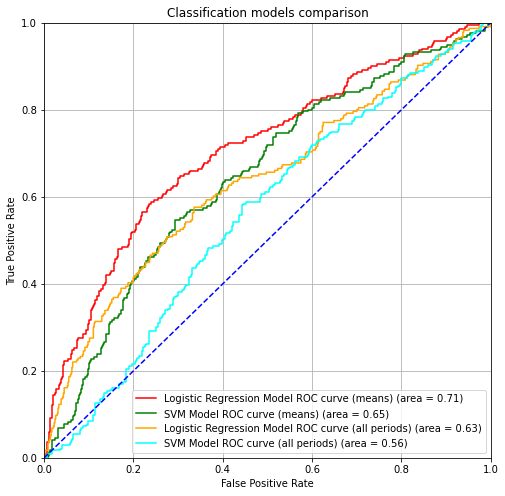

In [43]:
plt.figure(figsize=(8, 8))
plt.plot(logistic_fpr, logistic_tpr, color='red', label='Logistic Regression Model ROC curve (means) (area = %0.2f)' % auc_logistic)
plt.plot(svm_fpr, svm_tpr, color='green', label='SVM Model ROC curve (means) (area = %0.2f)' % auc_svm)

plt.plot(logistic_fpr_all, logistic_tpr_all,color='orange', label='Logistic Regression Model ROC curve (all periods) (area = %0.2f)' % auc_logistic_all)
plt.plot(svm_fpr_all, svm_tpr_all,color='cyan', label='SVM Model ROC curve (all periods) (area = %0.2f)' % auc_svm_all)

plt.plot([0, 1], [0, 1], linestyle='dashed', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification models comparison')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

# Final results and export

As we can see, the best model is Logistic Regression based on mean values of 12 periods data. So we will use it to submit final results.

In [27]:
df_train = pd.merge(tabular_df_means, train_df, on='id')
y_fin = df_train['target']
X_fin = df_train.drop(['period', 'id', 'target'], axis=1).fillna(method='bfill')

model = LogisticRegression(random_state=0, solver='newton-cg', multi_class='multinomial').fit(X_fin, y_fin)
print('Logistic Regr Means Score: ', model.score(X_fin, y_fin))

Logistic Regr Means Score:  0.7551420176297747


In [28]:
test_df_n = pd.merge(tabular_df_means, test_df, on='id')

X_pred = test_df_n.drop(['period', 'id', 'score'], axis=1).fillna(method='bfill')

result = model.predict_proba(X_pred)[:,1]
test_df['score'] = result.round(6)

In [29]:
# Export results to file
test_df.to_csv('HaidaTarasLR_test.txt', sep=',', index=False)